In [36]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from models import Encoder, GlobalDiscriminator, LocalDiscriminator, PriorDiscriminator
import os
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from pathlib import Path
import statistics as stats
import argparse
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset loading
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust size depending on your dataset
    transforms.ToTensor(),
])


In [60]:
class DeepInfoMaxLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=1.0, gamma=0.1):
        super().__init__()
        self.global_d = GlobalDiscriminator()
        self.local_d = LocalDiscriminator()
        self.prior_d = PriorDiscriminator()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, y, M, M_prime):

        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf

        y_exp = y.unsqueeze(-1).unsqueeze(-1)
        y_exp = y_exp.expand(-1, -1, 26, 26)

        y_M = torch.cat((M, y_exp), dim=1)
        y_M_prime = torch.cat((M_prime, y_exp), dim=1)

        Ej = -F.softplus(-self.local_d(y_M)).mean()
        Em = F.softplus(self.local_d(y_M_prime)).mean()
        LOCAL = (Em - Ej) * self.beta

        Ej = -F.softplus(-self.global_d(y, M)).mean()
        Em = F.softplus(self.global_d(y, M_prime)).mean()
        GLOBAL = (Em - Ej) * self.alpha

        prior = torch.rand_like(y)

        term_a = torch.log(self.prior_d(prior)).mean()
        term_b = torch.log(1.0 - self.prior_d(y)).mean()
        PRIOR = - (term_a + term_b) * self.gamma

        return LOCAL + GLOBAL + PRIOR


In [61]:
dataset = ImageFolder(root='C:\\Users\\safa5\\Downloads\\sinuse_Nose\\DATASET_SININUSE', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [62]:
# Initialize DIM model components
encoder = Encoder().to(device)
global_discriminator = GlobalDiscriminator().to(device)
local_discriminator = LocalDiscriminator().to(device)
prior_discriminator = PriorDiscriminator().to(device)

# Loss and Optimizer
#loss_fn = DeepInfoMaxLoss(encoder, global_discriminator, local_discriminator, prior_discriminator).to(device)
# Assuming DeepInfoMaxLoss is defined as in your provided code snippet
loss_fn = DeepInfoMaxLoss().to(device)
optimizer = torch.optim.Adam(loss_fn.parameters(), lr=1e-4)

In [63]:
batch_size = 32
ds_train_l = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True,
                                  pin_memory=torch.cuda.is_available())


In [64]:
encoder = Encoder().to(device)
loss_fn = DeepInfoMaxLoss().to(device)
optim = Adam(encoder.parameters(), lr=1e-4)
loss_optim = Adam(loss_fn.parameters(), lr=1e-4)

In [42]:
for epoch in range(500):
        batch = tqdm(ds_train_l, total=len(dataset) // batch_size)
        train_loss = []
        for x, target in batch:
            x = x.to(device)
            #print(x.shape)

            optim.zero_grad()
            loss_optim.zero_grad()
            y, M = encoder(x)
            #print(M.shape)


            # rotate images to create pairs for comparison
            M_prime = torch.cat((M[1:], M[0].unsqueeze(0)), dim=0)
            #print(M_prime.shape)
            loss = loss_fn(y, M, M_prime)
            train_loss.append(loss.item())
            batch.set_description(str(epoch) + ' Loss: ' + str(stats.mean(train_loss[-20:])))
            loss.backward()
            optim.step()
            loss_optim.step()

67 Loss: 1.5294173955917358: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.25s/it]


135 Loss: 1.2723338901996613: 100%|██████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.01s/it]


159 Loss: 1.1629563570022583: 100%|██████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.84s/it]


In [104]:
for epoch in range(500):
        batch = tqdm(ds_train_l, total=len(dataset) // batch_size)
        train_loss = []
        for x, target in batch:
            x = x.to(device)
            #print(x.shape)

            optim.zero_grad()
            loss_optim.zero_grad()
            y, M = encoder(x)
            #print(M.shape)


            # rotate images to create pairs for comparison
            M_prime = torch.cat((M[1:], M[0].unsqueeze(0)), dim=0)
            #print(M_prime.shape)
            loss = loss_fn(y, M, M_prime)
            train_loss.append(loss.item())
            batch.set_description(str(epoch) + ' Loss: ' + str(stats.mean(train_loss[-20:])))
            loss.backward()
            optim.step()
            loss_optim.step()

67 Loss: 1.2222135066986084: 100%|███████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.69s/it]


135 Loss: 1.1794005036354065: 100%|██████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.63s/it]


203 Loss: 1.1704941093921661: 100%|██████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.87s/it]


271 Loss: 0.9793650060892105: 100%|██████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.96s/it]


339 Loss: 1.0195208638906479: 100%|██████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.96s/it]


407 Loss: 1.0088194608688354: 100%|██████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.82s/it]


475 Loss: 0.8948663473129272: 100%|██████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.93s/it]


499 Loss: 0.8838528096675873: 100%|██████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.74s/it]


In [96]:
encoded_features = []
true_labels = []  # Assuming you have some labels

encoder.eval()  # If 'encoder' is your trained model
with torch.no_grad():
    for images, labels in data_loader:  # DataLoader for your labeled subset
        images = images.to(device)
        encoded, _ = encoder(images)
        encoded_features.extend(encoded.cpu().numpy())
        true_labels.extend(labels.numpy())

In [80]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming `encoded_features` is a 4D array with shape (n_samples, channels, height, width)
# Flatten the features
n_samples = len(encoded_features)
flattened_features = np.reshape(encoded_features, (n_samples, -1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(flattened_features, true_labels, test_size=0.1, random_state=42)

# Train the RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.93


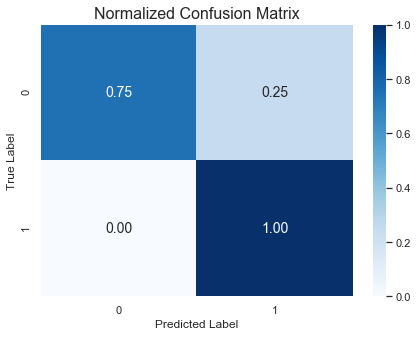

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, predictions)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
plt.figure(figsize=(7, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 14})  # Increase font size here
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Optional: Adjust the labels if you have specific class names

# Save the plot as a PNG file
plt.savefig('sinus_cm.png', dpi=300, bbox_inches='tight')  # Adjust dpi for resolution


plt.show()


In [82]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


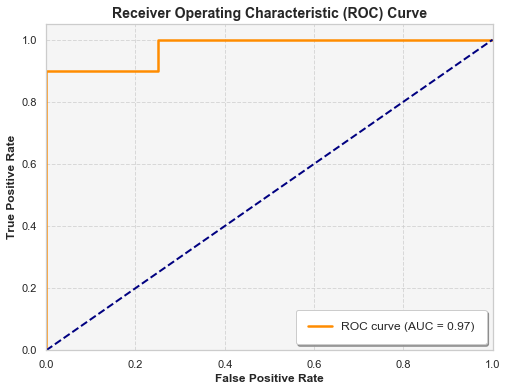

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nicer style using Seaborn
sns.set(style="whitegrid")

# ROC and AUC
# If you have more than two classes, you need to binarize the output
if len(np.unique(y_train)) == 2:  # Binary classification
    y_prob = classifier.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Enhanced Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2.5)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Set limits, labels, and title with enhanced styles
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, weight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, weight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, weight='bold')

    # Enhance the legend
    plt.legend(loc="lower right", fontsize=12, fancybox=True, framealpha=1, shadow=True, borderpad=1)

    # Add gridlines and set background color
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('whitesmoke')
    plt.savefig('sinusROC.png', dpi=300, bbox_inches='tight')  # Adjust dpi for resolution

    # Show the plot
    plt.show()

else:  # Multiclass case
    # Compute ROC for each class (One-vs-Rest)
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_auc_score

    n_classes = len(np.unique(y_train))
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
    y_pred_prob = classifier.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_prob[:, i])

        # Enhanced Plot ROC curve for each class
        plt.figure(figsize=(8, 6))
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})', lw=2.5, color=sns.color_palette("tab10")[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        # Set limits, labels, and title with enhanced styles
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12, weight='bold')
        plt.ylabel('True Positive Rate', fontsize=12, weight='bold')
        plt.title(f'ROC Curve for Class {i}', fontsize=14, weight='bold')

        # Enhance the legend
        plt.legend(loc="lower right", fontsize=12, fancybox=True, framealpha=1, shadow=True, borderpad=1)

        # Add gridlines and set background color
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('whitesmoke')
        
        # Save the plot as a PNG file
        plt.savefig('sinusROC.png', dpi=300, bbox_inches='tight')  # Adjust dpi for resolution


        # Show the plot
        plt.show()


C:\Users\safa5\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\safa5\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


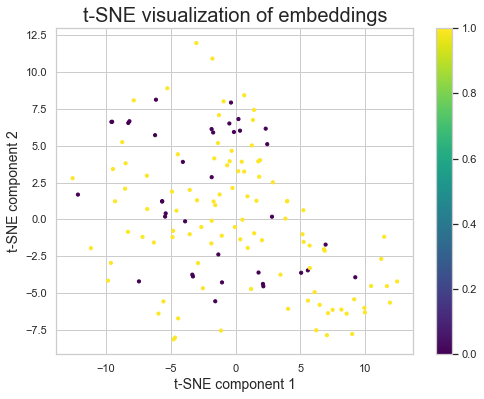

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

# Load embeddings using the model (encoder)
encoded_features = []
true_labels = []

encoder.eval()  # If 'encoder' is your trained model
with torch.no_grad():
    for images, labels in data_loader:  # DataLoader for your labeled subset
        images = images.to(device)
        encoded, _ = encoder(images)
        encoded_features.extend(encoded.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
encoded_features = np.array(encoded_features)
true_labels = np.array(true_labels)

# t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(encoded_features)

# Plotting the 2D embeddings
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=true_labels, cmap='viridis', s=10)
plt.colorbar(scatter)
plt.title("t-SNE visualization of embeddings", fontsize=20)
plt.xlabel("t-SNE component 1", fontsize=14)
plt.ylabel("t-SNE component 2", fontsize=14)
plt.show()


In [93]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, predictions, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.7500    0.8571         4
           1     0.9091    1.0000    0.9524        10

    accuracy                         0.9286        14
   macro avg     0.9545    0.8750    0.9048        14
weighted avg     0.9351    0.9286    0.9252        14



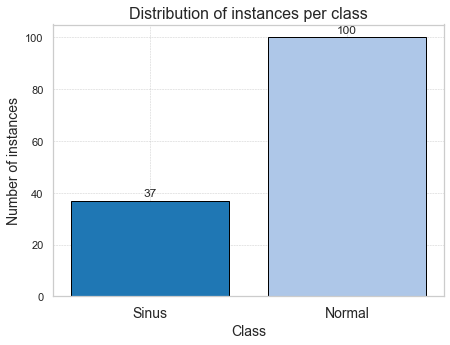

In [100]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# assuming `your_dataset` is an instance of a class that extends torch.utils.data.Dataset

# Create your DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Calculate the number of instances in each class
class_counts = {}
for _, label in dataloader:
    label = label.item()
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Sort the counts for better visualization
sorted_counts = dict(sorted(class_counts.items()))
 
# Create a color map with matplotlib colors
cmap = ListedColormap(plt.cm.tab20.colors)  # 'tab20' is a colormap with 20 distinct colors
class_names=['Sinus', 'Normal']
class_names
# Create a bar plot with colors
plt.figure(figsize=(7, 5))  # Make the figure larger
bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color=cmap.colors, edgecolor='black')

# Add labels and title with a larger font
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of instances', fontsize=14)
plt.title('Distribution of instances per class', fontsize=16)
# Set the x-ticks to match the class names
plt.xticks(range(len(sorted_counts)), class_names, fontsize=14)#, rotation=45)  # Add rotation for better label readability if needed

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 1), ha='center', va='bottom', fontsize=12)
# Save the plot
plt.savefig('sinus_distribution.png')
# Show the plot
plt.show()
